In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import FancyArrowPatch, Circle
import networkx as nx
import numpy as np
import os
import pandas as pd

In [10]:
# Set the working directory 
path_to_csvs = r"C:\Users\irs3th\test code"  
if not os.path.exists(path_to_csvs):
    raise FileNotFoundError(f"Cannot find the path: '{path_to_csvs}'")

# Verify
os.chdir(path_to_csvs)
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\irs3th\test code


In [12]:
# Read csv from build_dataset
transition_df = pd.read_csv('normalized_transitions_final.csv') # toy

In [13]:
# Filter for groups we want to plot
#groups_to_keep = ['dan_sd', 'lira_sd', 'orfo', 'LiCl', 'fed']

#transition_df = transition_df[transition_df['group'].isin(groups_to_keep)]

# Average normalized probability by group
avg_transition_matrix = transition_df.groupby('group').mean(numeric_only=True)
avg_transition_matrix=avg_transition_matrix.drop('id', axis=1) # averaged by accident above

## Directed plot (directionality with arrows)
### You can curve arrows so they don't overlap or save as eps and modify in Illustrator

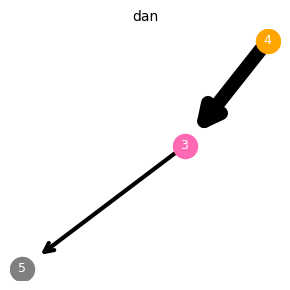

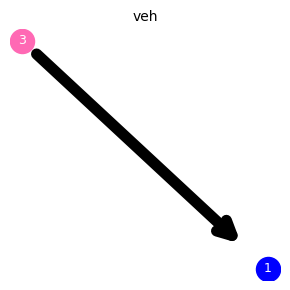

In [15]:
# Outline
filtered = avg_transition_matrix
min_edge_weight = 0.01 # Change as you want
max_arrow_width = 10 # Change as you want
plot_size = (3, 3) # Change as you want
output_dir = "network_eps_exports"
os.makedirs(output_dir, exist_ok=True)

# Node colors
node_colors = {
    'food motivated': 'blue',
    'drink': 'green',
    'move/explore': 'hotpink',
    'groom': 'orange',
    'rest/groom in shelter': 'grey'
    }

# Mappings
behavior_numbering = {b: i+1 for i, b in enumerate(node_colors)}
number_to_behavior = {v: k for k, v in behavior_numbering.items()}

# Global max weight for normalization (I use the overall max to weight individual groups)
global_max_weight = max(
    float(val)
    for _, row in filtered.iterrows()
    for col, val in row.items()
    if isinstance(val, (int, float)) and val > 0
)

# Plotting
for index, row in filtered.iterrows():
    group = index
    G = nx.DiGraph()

    for col, val in row.items():
        try:
            source, target = col.rsplit('_', 1)
            if source in behavior_numbering and target in behavior_numbering:
                weight = float(val)
                norm_weight = weight / global_max_weight
                if norm_weight >= min_edge_weight:
                    G.add_edge(behavior_numbering[source], behavior_numbering[target], weight=norm_weight)
        except:
            continue

    if G.number_of_edges() == 0:
        continue

    pos = nx.spring_layout(G, seed=42, k=0.4)
    fig, ax = plt.subplots(figsize=plot_size)

    # Draw nodes
    for node, (x, y) in pos.items():
        behavior = number_to_behavior[node]
        ax.scatter(x, y, s=300, color=node_colors[behavior], zorder=3) # Z order for visuals (node on top of arrows)
        ax.text(x, y, str(node), color='white', fontsize=9, ha='center', va='center', zorder=4)

    # Draw straight arrows
    for u, v, d in G.edges(data=True):
        if u == v:
            continue

        x1, y1 = pos[u]
        x2, y2 = pos[v]
        dx, dy = x2 - x1, y2 - y1

        # Offset endpoints a bit
        x1_adj = x1 + dx * 0.05
        y1_adj = y1 + dy * 0.05
        x2_adj = x2 - dx * 0.1
        y2_adj = y2 - dy * 0.1

        edge_width = min(0.5 + d['weight'] * max_arrow_width, max_arrow_width) # Scale

        arrow = FancyArrowPatch(
            (x1_adj, y1_adj), (x2_adj, y2_adj),
            arrowstyle='->',
            mutation_scale=10 + edge_width * 2,
            color='black',
            linewidth=edge_width, 
            zorder=1
        )
        ax.add_patch(arrow)

    ax.set_title(f"{group}", fontsize=10)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Save 
    filename = os.path.join(output_dir, f"{group.replace('/', '_')}.png")
    #plt.savefig(filename, format='eps', dpi=600)
    plt.close()

## Undirected graph (ball and stick)

In [ ]:
filtered = avg_transition_matrix

# Node colors
node_colors = {
    'food motivated': 'blue',
    'drink': 'green',
    'move/explore': 'hotpink',
    'groom': 'orange',
    'rest/groom in shelter': 'grey'
    }

behavior_numbering = {behavior: i + 1 for i, behavior in enumerate(node_colors)}
number_to_behavior = {v: k for k, v in behavior_numbering.items()}

global_max_weight = 0
for _, row in filtered.iterrows():
    for col, value in row.items():
        try:
            val = float(value)
            if val > 0:
                global_max_weight = max(global_max_weight, val)
        except Exception:
            continue

for index, row in filtered.iterrows():
    group = index
    G = nx.Graph() # Undirected for demonstration; weights are not visualized!


    for col, value in row.items():
        try:
            val = float(value)
            if val > 0:
                source, target = col.rsplit('_', 1)
                if source in behavior_numbering and target in behavior_numbering:
                    G.add_edge(behavior_numbering[source], behavior_numbering[target], weight=val)
        except Exception:
            continue

    pos = nx.spring_layout(G, seed=42, k=0.3)

    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    for node, (x, y) in pos.items():
        ax.scatter(x, y, s=400, color=node_colors[number_to_behavior[node]], zorder=3)

    for node, (x, y) in pos.items():
        ax.text(x, y, str(node), color='white', fontsize=10, ha='center', va='center', zorder=4)

    for u, v, d in G.edges(data=True):
        if u == v or d['weight'] <= 0.01:
            continue

        x1, y1 = pos[u]
        x2, y2 = pos[v]

        line = Line2D([x1, x2], [y1, y2],
                  linewidth=1,
                  color='black',
                  alpha=1,
                  zorder=2)
        ax.add_line(line)

        dx, dy = x2 - x1, y2 - y1
        x1_adj = x1 + dx * 0.05
        y1_adj = y1 + dy * 0.05
        x2_adj = x2 - dx * 0.1
        y2_adj = y2 - dy * 0.1

    plt.title(f"Behavior Transition Network (Numbered): {group}")
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig(f"networks__{group}.svg", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()